# Objective:

The city of Boston performs health inspection on licensed restaurants, and published its data for 2015. The inspection result is measured with a metric referred as the violation level. Also included in the data are other identifying features such as the restaurants' names, geographic locations. The data can be matched with other restaurant features, such as Yelp rating, price range, building age, gross revenue, etc., which can be highly correlated with the violation level. We aim to build a model to predict the potential voilation levels based on these features. More specifically, the goals are:
* To perform exploratory analysis on the data, mapping out specific violation types.
* To incorporate Yelp data such as customer ratings, price range, etc., in order to model the violation levels.
* To incorporate Zillow data and add property values as a predicting feature.
* To explore Yelp comments using NLP to extract potential violation types.

# Data

The food establish inspection data is available at:
https://data.cityofboston.gov/Health/Food-Establishment-Inspections/qndu-wx8w

Detailed explanation of the data:
http://www.cityofboston.gov/isd/health/foodcourt.asp

# Exploratory analysis

Loading python packages:

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re # string split with multiple delimiters
% matplotlib inline
from collections import Counter

Loading data:

In [2]:
InspDataRaw = pd.read_csv('Food_Establishment_Inspections.csv', low_memory=False)
InspDataRaw.columns

Index([u'﻿BusinessName', u'DBAName', u'LegalOwner', u'NameLast', u'NameFirst',
       u'LICENSENO', u'ISSDTTM', u'EXPDTTM', u'LICSTATUS', u'LICENSECAT',
       u'DESCRIPT', u'RESULT', u'RESULTDTTM', u'Violation', u'ViolLevel',
       u'ViolDesc', u'VIOLDTTM', u'ViolStatus', u'StatusDate', u'Comments',
       u'Address', u'City', u'State', u'Zip', u'Property_ID', u'Location'],
      dtype='object')

# Types and levels of violation

## Violation types

We first examine the types violations, labeled as "Violation". Repeated violations might have happened for the same BusinessName, but for this step, we do not combine results for the same business.

The violation types are categorized by the first digit/letter in the violation code, according to the description:
http://www.cityofboston.gov/isd/health/violationcodes.asp

### Categorizing violation types

In [3]:
noVio = {0:['nan']} # No violation
foodProt = {1:['M']} # Food Protection Management
food = {2:[str(x).zfill(2) for x in range(1,3)]} # Food
timeTemp = {3:[str(x).zfill(2) for x in range(3,7)]} # Food Protection, Time & Temperature Controls
contam = {4:[str(x).zfill(2) for x in range(7,11)]} # Food Protection From Contamination
pers = {5:[str(x).zfill(2) for x in range(11,14)]} # Personnel
eq = {6:[str(x).zfill(2) for x in range(14,27)]} # Equipment and Utensils
wat = {7:['27']} # water
sew = {8:['28']} # sewage
plumb = {9:['29','30']} # plumbing
wc = {10:['31','32']} # Toilet and Handwashing Facilities
disp = {11:['33','34']} # Refuse Disposal
anim = {12:['35']} # Insect, Rodent, Animal Control
physFac = {13:[str(x).zfill(2) for x in range(37,41)]} # Physical Facilities
othOp = {14:[str(x).zfill(2) for x in range(41,45)]} # Other Operations
highPop = {15:['45']} # Highly Susceptible Populations
unkn = {16:['36','46']}

def merge_dicts(*dict_args): # merging dictinary together, used later
    '''
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    '''
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result

VioDict = merge_dicts(noVio,foodProt,food,timeTemp,contam,pers,eq,wat,sew,plumb,wc,disp,anim,physFac,othOp,highPop,unkn)
VioValues = [] # all accepted values for InspDataRaw.Violation
for vioValue in VioDict.values():
    VioValues += vioValue

VioCode = {0:'Pass',
           1:'Food Protection Management',
           2:'Food',
           3:'Food Protection, Time & Temperature Controls',
           4:'Food Protection From Contamination',
           5:'Personnel',
           6:'Equipment and Utensils',
           7:'Water',
           8:'Sewage',
           9:'Plumbing',
           10:'Toilet and Handwashing Facilities',
           11:'Refuse Disposal',
           12:'Insect, Rodent, Animal Control',
           13:'Physical Facilities',
           14:'Other Operations',
           15:'Highly Susceptible Populations',
           16:'unknown code'}


### Cleaning data according to violation types:

In [8]:
def categ_vioTypes(vioType, VioDict): # used to categorize violation types
    '''
    Given a string of vioType, categorize it according to the VioDict dictionary
    '''
    VioKeys = VioDict.keys()
    VioValues = VioDict.values()
    for i in range(len(VioValues)):
        if vioType in VioValues[i]:
            vioCode = VioKeys[i]
    return vioCode

# Keeping rows with only violation types matched to codes
InspDataClean = InspDataRaw.loc[InspDataRaw.Violation.astype('S32').apply(lambda x: x.split('-')[0] in VioValues),:]
# Replace raw data Violation codes with our category codes
Violation_cat = InspDataClean.Violation.astype('S32').apply(lambda x: categ_vioTypes(x.split('-')[0],VioDict))
InspDataClean.loc[:,'Violation'] = Violation_cat



### Variation of violation types:

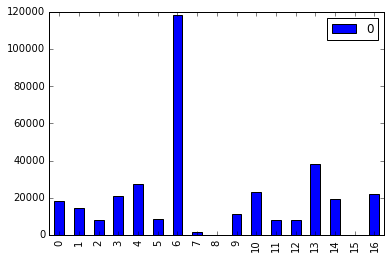

In [9]:
VioTypes_hist = pd.DataFrame.from_dict(Counter(InspDataClean.loc[:,'Violation']), orient='index')
VioTypes_hist.plot(kind='bar')

## Levels of violation

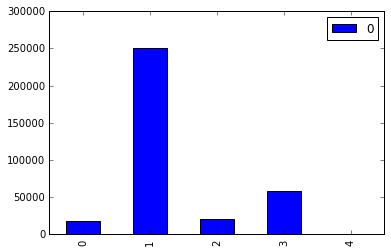

In [11]:
def transVioLevel(vioLevel_star): # Function to translate original violation level to numerical values
    if vioLevel_star == 'nan':
        vioLevel = 0
    else: vioLevel = len(vioLevel_star)
    return vioLevel

ViolLevel_trans = InspDataClean.ViolLevel.astype('S32').apply(transVioLevel)
InspDataClean.loc[:,'ViolLevel'] = ViolLevel_trans

ViolLevel_hist = pd.DataFrame.from_dict(Counter(InspDataClean.loc[:,'ViolLevel']), orient='index')
ViolLevel_hist.plot(kind='bar')

# Location of restaurants

First visualization of types and levels of inspection with restaurant location. First clean data further so all entries have location data.

In [127]:
InspDataClean = InspDataClean.loc[InspDataClean.Location.astype('S32').apply(lambda x: x !='nan'),:]
LocLati = InspDataClean.Location.astype('S32').apply(lambda x: re.split('\(|,|\)',x)[1])
LocLong = InspDataClean.Location.astype('S32').apply(lambda x: re.split('\(|,|\)',x)[2])
InspDataClean['LocLati'] = LocLati
InspDataClean['LocLong'] = LocLong

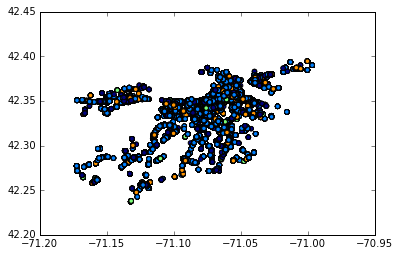

In [128]:
# plotting violation level according to locations
plt.scatter(InspDataClean.LocLong.astype(float),InspDataClean.LocLati.astype(float),c = InspDataClean.ViolLevel)

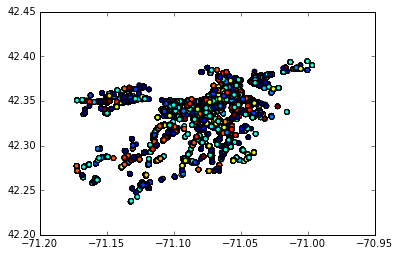

In [129]:
# plotting violation types according to locations
plt.scatter(InspDataClean.LocLong.astype(float),InspDataClean.LocLati.astype(float),c = InspDataClean.Violation)

# Property assesment of restaurants

The violation type and level can be highly correlated with the locations, in terms of their financial values. This can be obtained from the property value assessment. One source of this can be found fromm the city of Boston property assessment data:


In [48]:
a

'(42.345875, -71.064496)'

In [49]:
dtype('asdf')

NameError: name 'dtype' is not defined